In [1]:
import sys
sys.path.append('../')
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import seaborn as sns
from scipy.spatial.distance import cdist
from utils.utils import *
from utils.ccf_utils import *
from scipy import stats, spatial
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list, fcluster
from scipy.signal import find_peaks


#plt.rcParams['font.family'] = 'Arial'

def readSWC(swc_path, mode='simple'):
    n_skip = 0
    with open(swc_path, "r") as f:
        for line in f.readlines():
            line = line.strip()
            if line.startswith("#"):
                n_skip += 1
            else:
                break
    names = ["##n", "type", "x", "y", "z", "r", "parent"]
    used_cols = [0, 1, 2, 3, 4, 5, 6]
    if mode == 'simple':
        pass
    df = pd.read_csv(swc_path, index_col=0, skiprows=n_skip, sep=" ",
                     usecols=used_cols,
                     names=names
                     )

    return df



In [2]:
import json
with open('../../data/region2primaryRegion.json', 'r') as f:
    region2primaryRegion = json.load(f)

In [3]:
soma_feature = pd.read_csv('../../data/155k_DEN_soma_feature.csv', sep=',', index_col=0)

soma_feature

,x,y,z,source_region,source_region_withCorticalRegion
swc_id,,,,,
SEU-ALLEN_local_15257_10001_19868_8155_CCFv3.swc,11287.600,3667.825,5563.125,fiber tracts,arb
SEU-ALLEN_local_15257_10008_10862_6996_CCFv3.swc,9625.025,3764.025,9017.726,ENTm,ENTm5
SEU-ALLEN_local_15257_10012_10978_7039_CCFv3.swc,9682.675,3754.125,8985.000,ENTm,ENTm5
SEU-ALLEN_local_15257_10020_17924_8129_CCFv3.swc,11267.750,3630.950,6364.775,fiber tracts,arb
SEU-ALLEN_local_15257_10028_28224_6732_CCFv3.swc,9298.925,3983.150,2374.200,SUB,SUB
...,...,...,...,...,...
SEU-ALLEN_local_236174_7626_18076_3068_CCFv3.swc,3998.550,1907.975,5585.175,ACAd,ACAd1
SEU-ALLEN_local_236174_8122_17844_3762_CCFv3.swc,4842.475,2017.425,5512.275,ACAd,ACAd2/3
SEU-ALLEN_local_236174_8813_17916_4826_CCFv3.swc,5990.175,2143.925,5498.300,ACAv,ACAv2/3


In [4]:
den_contact = pd.read_csv('../../data/ppss_from_pacs.csv', sep=',', index_col=0)

den_contact

,Unnamed: 0,x,y,z,source_cell,target_cell,branch_level,target_region,color
0,0,6719.33,4732.66,4685.44,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
1,1,6719.74,4733.37,4685.04,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
2,2,6720.34,4733.72,4684.31,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
3,3,6720.94,4734.06,4683.59,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
4,4,6686.39,4743.11,4648.30,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,6,VAL,#acc2d9
...,...,...,...,...,...,...,...,...,...
17995300,22299324,3283.52,3644.60,8860.40,pre_18868_00465,SEU-ALLEN_local_201584_8835_21199_4542_CCFv3.swc,9,MOp,#1f77b4
17995301,22299325,3283.40,3647.35,8860.64,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995302,22299326,3283.27,3646.37,8860.83,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995303,22299327,3283.14,3645.40,8861.01,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4


In [5]:
soma_feature = soma_feature[soma_feature['source_region'].isin(list(den_contact['target_region'].unique()))].copy()
soma_feature

,x,y,z,source_region,source_region_withCorticalRegion
swc_id,,,,,
SEU-ALLEN_local_15257_10001_19868_8155_CCFv3.swc,11287.600,3667.825,5563.125,fiber tracts,arb
SEU-ALLEN_local_15257_10008_10862_6996_CCFv3.swc,9625.025,3764.025,9017.726,ENTm,ENTm5
SEU-ALLEN_local_15257_10012_10978_7039_CCFv3.swc,9682.675,3754.125,8985.000,ENTm,ENTm5
SEU-ALLEN_local_15257_10020_17924_8129_CCFv3.swc,11267.750,3630.950,6364.775,fiber tracts,arb
SEU-ALLEN_local_15257_10028_28224_6732_CCFv3.swc,9298.925,3983.150,2374.200,SUB,SUB
...,...,...,...,...,...
SEU-ALLEN_local_236174_7626_18076_3068_CCFv3.swc,3998.550,1907.975,5585.175,ACAd,ACAd1
SEU-ALLEN_local_236174_8122_17844_3762_CCFv3.swc,4842.475,2017.425,5512.275,ACAd,ACAd2/3
SEU-ALLEN_local_236174_8813_17916_4826_CCFv3.swc,5990.175,2143.925,5498.300,ACAv,ACAv2/3


In [6]:
soma_ct = soma_feature['source_region'].value_counts()
del soma_ct['fiber tracts']
# soma_ct = soma_ct[0:35]
soma_ct = soma_ct[soma_ct>=30]
shared_list = list(set(soma_ct.index).intersection(den_contact['target_region'].unique()))
soma_ct

source_region
CP     21802
MOB    16644
IC      6709
AN      4770
CUL     4444
       ...  
SNc       32
APN       32
CA2       31
FN        31
SMT       30
Name: count, Length: 175, dtype: int64

In [138]:
sele_region = region2primaryRegion.keys()
order_list = []

for i in sele_region:
    if i in list(soma_ct.index):
        order_list.append(i)

print(order_list)
print(len(order_list))

['FRP', 'MOp', 'MOs', 'SSp-n', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-ul', 'SSp-tr', 'SSp-un', 'SSs', 'GU', 'VISC', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'VISal', 'VISam', 'VISl', 'VISp', 'VISpl', 'VISpm', 'VISli', 'VISpor', 'ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'AId', 'AIp', 'AIv', 'RSPagl', 'RSPd', 'RSPv', 'VISa', 'VISrl', 'TEa', 'PERI', 'ECT', 'MOB', 'AOB', 'AON', 'TT', 'DP', 'PIR', 'NLOT', 'COAa', 'COAp', 'PAA', 'TR', 'CA1', 'CA2', 'CA3', 'DG', 'ENTl', 'ENTm', 'PAR', 'POST', 'PRE', 'SUB', 'ProS', 'HATA', 'APr', 'CLA', 'EPd', 'EPv', 'LA', 'BLA', 'BMA', 'PA', 'CP', 'ACB', 'FS', 'OT', 'LSc', 'LSr', 'LSv', 'SF', 'AAA', 'CEA', 'IA', 'MEA', 'GPe', 'SI', 'MA', 'MS', 'NDB', 'TRS', 'BST', 'VM', 'VPL', 'VPM', 'MG', 'LGd', 'LP', 'PO', 'AM', 'MD', 'SMT', 'PVT', 'PT', 'RE', 'CM', 'RT', 'IGL', 'LGv', 'ARH', 'DMH', 'MPO', 'SBPV', 'SCH', 'AHN', 'TMv', 'MPN', 'PMv', 'PH', 'LHA', 'PSTN', 'TU', 'ZI', 'SCs', 'IC', 'SNr', 'VTA', 'MRN', 'SCm', 'PAG', 'APN', 'SNc', 'DR', 'NLL', 'PSV', 'PB', 'SOC',

## branch-level distribution in same source regions

In [8]:
den_contact = den_contact[den_contact['target_region'].isin(order_list)]
den_contact

,Unnamed: 0,x,y,z,source_cell,target_cell,branch_level,target_region,color
20,20,2963.27,2784.95,3914.27,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_9293_13363_2479_CCFv3.swc,8,MOs,#56ae57
21,21,2810.66,2770.75,3799.39,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
22,22,2811.53,2770.50,3798.97,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
23,23,2812.41,2770.25,3798.56,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
24,24,2813.28,2770.00,3798.14,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
...,...,...,...,...,...,...,...,...,...
17995300,22299324,3283.52,3644.60,8860.40,pre_18868_00465,SEU-ALLEN_local_201584_8835_21199_4542_CCFv3.swc,9,MOp,#1f77b4
17995301,22299325,3283.40,3647.35,8860.64,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995302,22299326,3283.27,3646.37,8860.83,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995303,22299327,3283.14,3645.40,8861.01,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4


In [9]:
den_contact['count'] = 1

wide_df2_ = den_contact.pivot_table(index='target_region', columns=['branch_level'], 
                        values=['count'], aggfunc='sum', fill_value=0
                       )

wide_df2_.columns.name = ''
wide_df2_.columns = [i[1] for i in wide_df2_.columns]
wide_df2_.index.name = ''
wide_df2_

C:\Users\yishui\AppData\Local\Temp\ipykernel_42480\2759431918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  den_contact['count'] = 1


,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
,,,,,,,,,,,,,,,,,,,,,
AAA,144,673,853,823,829,399,335,121,55,26,...,0,0,0,0,0,0,0,0,0,0
ACAd,3665,11133,22013,31999,32171,25411,19162,12339,6836,4134,...,142,29,0,0,0,0,0,0,0,0
ACAv,3036,8519,15984,19129,19563,17962,13964,9883,5966,3474,...,198,45,84,26,22,0,0,0,0,0
ACB,35287,113875,214127,286363,289798,236846,164850,94084,49795,25866,...,1258,329,165,126,14,0,0,0,0,0
AHN,367,1803,2026,2249,1289,603,282,192,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM,1266,4916,10949,18066,24360,25883,22083,17962,10437,5787,...,136,99,9,0,0,0,0,0,0,0
VPL,445,2387,3129,2718,3789,3710,2792,2853,1707,856,...,87,9,0,0,0,0,0,0,0,0
VPM,1638,5430,6753,7372,8506,7042,6135,4801,3161,1427,...,50,49,8,4,0,0,0,0,0,0


In [139]:
wide_df2 = wide_df2_.copy()

for i in wide_df2.index:
    wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]
wide_df2 = (wide_df2.T / wide_df2.sum(axis=1)).T

wide_df2

C:\Users\yishui\AppData\Local\Temp\ipykernel_42480\3388474175.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]
C:\Users\yishui\AppData\Local\Temp\ipykernel_42480\3388474175.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.010416666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]
C:\Users\yishui\AppData\Local\Temp\ipykernel_42480\3388474175.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.885416666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype fi

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
,,,,,,,,,,,,,,,,,,,,,
AAA,0.033279,0.155535,0.197134,0.190201,0.191588,0.092212,0.077421,0.027964,0.012711,0.006009,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ACAd,0.021269,0.064607,0.127745,0.185695,0.186693,0.147464,0.111200,0.071605,0.039670,0.023990,...,0.000824,0.000168,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ACAv,0.025161,0.070602,0.132469,0.158534,0.162131,0.148862,0.115728,0.081906,0.049444,0.028791,...,0.001641,0.000373,0.000696,0.000215,0.000182,0.0,0.0,0.0,0.0,0.0
ACB,0.022992,0.074198,0.139520,0.186587,0.188825,0.154323,0.107412,0.061303,0.032445,0.016854,...,0.000820,0.000214,0.000108,0.000082,0.000009,0.0,0.0,0.0,0.0,0.0
AHN,0.041652,0.204631,0.229940,0.255249,0.146294,0.068437,0.032005,0.021791,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM,0.008595,0.033374,0.074331,0.122648,0.165377,0.175716,0.149919,0.121942,0.070855,0.039287,...,0.000923,0.000672,0.000061,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
VPL,0.017707,0.094979,0.124503,0.108149,0.150764,0.147621,0.111093,0.113521,0.067921,0.034060,...,0.003462,0.000358,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
VPM,0.030413,0.100821,0.125385,0.136878,0.157934,0.130751,0.113911,0.089142,0.058691,0.026496,...,0.000928,0.000910,0.000149,0.000074,0.000000,0.0,0.0,0.0,0.0,0.0


In [140]:
wide_df2.columns

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23],
      dtype='int64')

In [141]:
for i in range(1, max(wide_df2.columns)+1):
    if i not in list(wide_df2.columns):
        wide_df2[i] = 0

wide_df2 = wide_df2.loc[order_list, list(range(1, 11))]
wide_df2

,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,
FRP,0.017579,0.066266,0.129408,0.176378,0.191863,0.134970,0.097202,0.091502,0.046592,0.031210
MOp,0.013420,0.053104,0.105042,0.146689,0.167472,0.155730,0.128246,0.088982,0.057479,0.037851
MOs,0.015382,0.055973,0.105977,0.153184,0.175591,0.156832,0.125408,0.083586,0.052981,0.032014
SSp-n,0.016361,0.062857,0.112946,0.168661,0.165004,0.150396,0.119298,0.087626,0.058388,0.028318
SSp-bfd,0.018052,0.064102,0.120884,0.161387,0.174844,0.150261,0.116358,0.080523,0.053834,0.028088
...,...,...,...,...,...,...,...,...,...,...
SIM,0.010309,0.319588,0.144330,0.051546,0.113402,0.195876,0.020619,0.082474,0.061856,0.000000
AN,0.200000,0.356522,0.217391,0.139130,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000
COPY,0.000000,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000


In [142]:
wide_df2 = (wide_df2 - wide_df2.mean(axis=0)) / wide_df2.std(axis=0)
wide_df2

,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,
FRP,-0.683141,-0.570400,-0.513888,-0.149753,0.370660,0.334214,0.534550,1.274714,0.839875,0.963431
MOp,-0.806710,-0.676841,-0.803616,-0.546624,-0.006283,0.746010,1.252889,1.201893,1.302015,1.347877
MOs,-0.748427,-0.653642,-0.792501,-0.459792,0.119182,0.767871,1.187228,1.045962,1.111065,1.009980
SSp-n,-0.719344,-0.597969,-0.709636,-0.252904,-0.044429,0.640203,1.045827,1.162690,1.340594,0.795969
SSp-bfd,-0.669107,-0.587900,-0.615246,-0.350142,0.107650,0.637531,0.977800,0.957431,1.147289,0.782685
...,...,...,...,...,...,...,...,...,...,...
SIM,-0.899127,1.478255,-0.336449,-1.818450,-0.841910,1.542342,-1.237513,1.013831,1.487785,-0.843377
AN,4.736331,1.776947,0.532322,-0.647660,-1.250613,-2.343028,-1.714607,-1.369458,-1.137902,-0.843377
COPY,-1.205401,-1.106305,-2.052670,6.404241,2.557019,-2.343028,-1.714607,-1.369458,-1.137902,-0.843377


In [143]:
eucl_df = pd.DataFrame(np.zeros((len(wide_df2.index), len(wide_df2.index))),
                     index=order_list, columns=order_list
                    )

for i in wide_df2.index:
    for j in wide_df2.index:
        tmp= np.linalg.norm(wide_df2.loc[i, :]*np.arange(1,11) - wide_df2.loc[j, :]*np.arange(1,11))
        # tmp= np.linalg.norm(wide_df2.loc[i, :] - wide_df2.loc[j, :])
        eucl_df.loc[i, j] = tmp

# eucl_df = corr_df*1
# eucl_df = corr_df.round(3)
eucl_df

,FRP,MOp,MOs,SSp-n,SSp-bfd,SSp-ll,SSp-m,SSp-ul,SSp-tr,SSp-un,...,SPIV,CENT,CUL,DEC,FOTU,SIM,AN,COPY,PFL,FL
FRP,0.000000,8.408108,6.404366,6.702398,5.724446,8.351320,6.911914,9.675933,8.961944,7.251199,...,39.601605,28.895253,39.089040,45.227824,46.422918,25.877746,41.564569,49.256327,65.701922,49.660221
MOp,8.408108,0.000000,4.083661,5.891676,6.569013,6.928341,2.394344,2.854230,13.731303,7.191952,...,45.981273,35.304887,44.054255,51.287742,51.364306,29.594570,47.647498,55.792229,62.464092,55.253898
MOs,6.404366,4.083661,0.000000,3.565824,3.006161,3.856539,2.476156,4.132718,9.994392,3.403160,...,42.868597,31.960344,41.056784,48.538163,48.850933,27.155830,44.772353,52.965239,65.895615,52.710848
SSp-n,6.702398,5.891676,3.565824,0.000000,2.603914,4.299801,3.788668,5.363593,8.780038,3.349486,...,42.546654,31.858624,40.933373,48.485827,48.585706,25.106345,44.446798,52.594849,67.299221,51.947712
SSp-bfd,5.724446,6.569013,3.006161,2.603914,0.000000,3.946525,4.478088,6.318309,7.779871,2.316195,...,40.763629,29.865426,39.121947,46.524445,47.052862,24.875949,42.660491,51.076695,67.651692,50.782378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIM,25.877746,29.594570,27.155830,25.106345,24.875949,24.752533,27.468661,28.332467,21.234662,25.092894,...,41.270894,31.773058,34.635764,43.678196,41.336087,0.000000,39.263038,53.856409,81.568297,50.579728
AN,41.564569,47.647498,44.772353,44.446798,42.660491,45.126525,46.247824,48.037920,39.082602,43.701410,...,14.234509,16.111470,16.296909,21.720188,17.443074,39.263038,0.000000,35.872231,90.269624,29.111692
COPY,49.256327,55.792229,52.965239,52.594849,51.076695,53.454556,54.411029,56.766234,47.613767,51.788586,...,22.993806,31.921680,43.429588,43.370930,46.858996,53.856409,35.872231,0.000000,97.299000,26.470130
PFL,65.701922,62.464092,65.895615,67.299221,67.651692,68.482999,64.189591,64.283636,74.147603,69.113876,...,91.224850,85.075802,90.089295,92.930698,90.884080,81.568297,90.269624,97.299000,0.000000,95.511373


23.622723877523352 21.549429547873657 97.29899978628423


<Axes: ylabel='Count'>

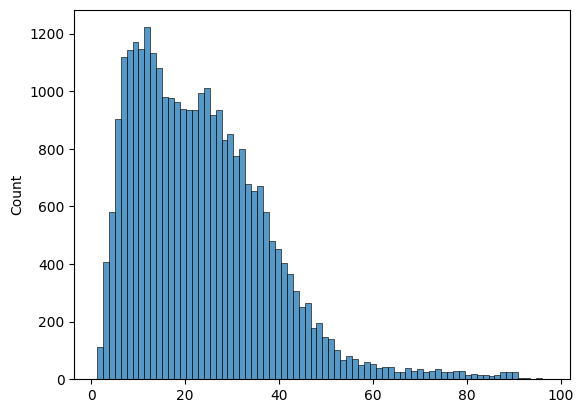

In [144]:
v = eucl_df.values.reshape(-1)
v = v[v>0]
print(np.mean(v), np.median(v), np.max(v))

alpha = np.median(v)

sns.histplot(v)

In [145]:
eucl_df = np.e**(-eucl_df/alpha)
eucl_df

,FRP,MOp,MOs,SSp-n,SSp-bfd,SSp-ll,SSp-m,SSp-ul,SSp-tr,SSp-un,...,SPIV,CENT,CUL,DEC,FOTU,SIM,AN,COPY,PFL,FL
FRP,1.000000,0.676937,0.742900,0.732696,0.766713,0.678723,0.725607,0.638259,0.659760,0.714272,...,0.159182,0.261615,0.163013,0.122604,0.115990,0.300937,0.145322,0.101699,0.047411,0.099811
MOp,0.676937,1.000000,0.827371,0.760786,0.737245,0.725054,0.894841,0.875946,0.528771,0.716238,...,0.118392,0.194306,0.129466,0.092550,0.092222,0.253261,0.109582,0.075092,0.055098,0.076992
MOs,0.742900,0.827371,1.000000,0.847494,0.869792,0.836137,0.891450,0.825490,0.628896,0.853915,...,0.136789,0.226929,0.148787,0.105145,0.103630,0.283607,0.125223,0.085619,0.046987,0.086636
SSp-n,0.732696,0.760786,0.847494,1.000000,0.886181,0.819114,0.838775,0.779660,0.665353,0.856045,...,0.138848,0.228003,0.149642,0.105401,0.104914,0.311904,0.127129,0.087103,0.044024,0.089759
SSp-bfd,0.766713,0.737245,0.869792,0.886181,1.000000,0.832653,0.812365,0.745872,0.696962,0.898092,...,0.150825,0.250098,0.162764,0.115445,0.112648,0.315257,0.138117,0.093461,0.043310,0.094746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIM,0.300937,0.253261,0.283607,0.311904,0.315257,0.317068,0.279520,0.268537,0.373292,0.312099,...,0.147316,0.228910,0.200434,0.131745,0.146871,1.000000,0.161702,0.082150,0.022705,0.095641
AN,0.145322,0.109582,0.125223,0.127129,0.138117,0.123182,0.116936,0.107615,0.163062,0.131604,...,0.516566,0.473477,0.469420,0.364976,0.445105,0.161702,1.000000,0.189257,0.015162,0.259000
COPY,0.101699,0.075092,0.085619,0.087103,0.093461,0.083697,0.080063,0.071774,0.109754,0.090424,...,0.344030,0.227337,0.133274,0.133637,0.113666,0.082150,0.189257,1.000000,0.010942,0.292777
PFL,0.047411,0.055098,0.046987,0.044024,0.043310,0.041671,0.050858,0.050637,0.032039,0.040469,...,0.014505,0.019294,0.015290,0.013401,0.014736,0.022705,0.015162,0.010942,1.000000,0.011888


In [146]:
# eucl_df.to_csv("./branch_order_similarity_with_174_regions.csv")

In [147]:
primary_region_list = []

for i in wide_df2.index:
    primary_region_list.append(region2primaryRegion[i])

In [148]:
wide_df2

,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,
FRP,-0.683141,-0.570400,-0.513888,-0.149753,0.370660,0.334214,0.534550,1.274714,0.839875,0.963431
MOp,-0.806710,-0.676841,-0.803616,-0.546624,-0.006283,0.746010,1.252889,1.201893,1.302015,1.347877
MOs,-0.748427,-0.653642,-0.792501,-0.459792,0.119182,0.767871,1.187228,1.045962,1.111065,1.009980
SSp-n,-0.719344,-0.597969,-0.709636,-0.252904,-0.044429,0.640203,1.045827,1.162690,1.340594,0.795969
SSp-bfd,-0.669107,-0.587900,-0.615246,-0.350142,0.107650,0.637531,0.977800,0.957431,1.147289,0.782685
...,...,...,...,...,...,...,...,...,...,...
SIM,-0.899127,1.478255,-0.336449,-1.818450,-0.841910,1.542342,-1.237513,1.013831,1.487785,-0.843377
AN,4.736331,1.776947,0.532322,-0.647660,-1.250613,-2.343028,-1.714607,-1.369458,-1.137902,-0.843377
COPY,-1.205401,-1.106305,-2.052670,6.404241,2.557019,-2.343028,-1.714607,-1.369458,-1.137902,-0.843377


In [158]:
order_list = ['MOp', 'MOs', 'SSp-n', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-ul', 'SSp-un', 'SSs', 
              'VISp', 'AId', 'RSPv', 'CLA', 'CP', 'VM', 'VPL', 'VPM', 'LGd', 
              'RT']
for i in order_list:
    print(i,region2primaryRegion[i])

MOp Isocortex
MOs Isocortex
SSp-n Isocortex
SSp-bfd Isocortex
SSp-ll Isocortex
SSp-m Isocortex
SSp-ul Isocortex
SSp-un Isocortex
SSs Isocortex
VISp Isocortex
AId Isocortex
RSPv Isocortex
CLA CTXsp
CP STR
VM TH
VPL TH
VPM TH
LGd TH
RT TH


In [168]:
eucl_df = pd.read_csv('../figure1/eucl_region_similarity_using174_region.csv', sep=',', index_col=0)

eucl_df

,FRP,MOp,MOs,SSp-n,SSp-bfd,SSp-ll,SSp-m,SSp-ul,SSp-tr,SSp-un,...,SPIV,CENT,CUL,DEC,FOTU,SIM,AN,COPY,PFL,FL
FRP,1.000000,0.701205,0.746701,0.760539,0.791235,0.676851,0.739575,0.647752,0.746334,0.736902,...,0.134753,0.302799,0.154543,0.083386,0.052803,0.299386,0.093394,0.076032,0.118016,0.070755
MOp,0.701205,1.000000,0.874966,0.817356,0.795955,0.786861,0.918361,0.879372,0.637598,0.794357,...,0.106974,0.234783,0.134376,0.068398,0.048277,0.279184,0.077648,0.059424,0.129291,0.058719
MOs,0.746701,0.874966,1.000000,0.869013,0.884186,0.851463,0.915525,0.837040,0.713349,0.894804,...,0.116122,0.257584,0.142511,0.072146,0.050072,0.291861,0.082741,0.064222,0.117162,0.062239
SSp-n,0.760539,0.817356,0.869013,1.000000,0.900155,0.802306,0.873557,0.792269,0.751525,0.865196,...,0.120854,0.265055,0.146522,0.072817,0.050975,0.305422,0.085317,0.066640,0.113474,0.066466
SSp-bfd,0.791235,0.795955,0.884186,0.900155,1.000000,0.810548,0.852457,0.770874,0.775751,0.895481,...,0.126289,0.283654,0.154039,0.078130,0.052340,0.309706,0.089718,0.068243,0.112104,0.066529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIM,0.299386,0.279184,0.291861,0.305422,0.309706,0.311342,0.293598,0.291249,0.330487,0.299581,...,0.097678,0.220708,0.217350,0.084030,0.094220,1.000000,0.099072,0.041921,0.083254,0.057002
AN,0.093394,0.077648,0.082741,0.085317,0.089718,0.079552,0.080415,0.076875,0.094590,0.083111,...,0.318483,0.240166,0.141139,0.079462,0.079608,0.099072,1.000000,0.043231,0.034422,0.063730
COPY,0.076032,0.059424,0.064222,0.066640,0.068243,0.060793,0.061972,0.054752,0.075859,0.066175,...,0.124652,0.100852,0.043797,0.029805,0.021443,0.041921,0.043231,1.000000,0.020892,0.174615
PFL,0.118016,0.129291,0.117162,0.113474,0.112104,0.108920,0.123260,0.122335,0.093388,0.105935,...,0.036082,0.060628,0.048743,0.027647,0.035144,0.083254,0.034422,0.020892,1.000000,0.025671


In [169]:
major_list = []
color_list = []

primary_color = {'Isocortex': '#1f77b4', 'OLF': '#aec7e8', 'HPF': '#ff7f0e', 'CTXsp': '#ffbb78', 
                 'STR': '#2ca02c', 'PAL': '#98df8a', 'TH': '#d62728', 'HY': '#ff9896', 
                 'MB': '#9467bd', 'P': '#c5b0d5', 'MY': '#8c564b', 'CBX': '#c49c94'}

for i in eucl_df.index:
    major_list.append(region2primaryRegion[i])
    color_list.append(primary_color[region2primaryRegion[i]])
#major_list

In [170]:
order_list = []

for i in ['Isocortex', 'OLF', 'HPF', 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY',]:
    tmp_list = []
    for j in eucl_df.index:
        if region2primaryRegion[j] == i:
            tmp_list.append(j)
    tmp_df = eucl_df.loc[tmp_list, tmp_list]
    if len(tmp_df) > 1:
        Z = linkage(tmp_df.values, method = 'weighted', metric='euclidean',)
        tmp_df = tmp_df.iloc[leaves_list(Z), leaves_list(Z)]
    
    order_list = order_list + list(tmp_df.index)

order_df = eucl_df.loc[order_list, order_list].copy()
order_df

,PERI,ILA,TEa,ECT,VISal,VISli,AIp,RSPv,SSp-m,MOs,...,GRN,IRN,IO,NTS,PARN,SPVI,PGRNd,CU,MDRNd,MDRNv
PERI,1.000000,0.731669,0.756512,0.729776,0.561177,0.670494,0.713994,0.320085,0.412235,0.432687,...,0.391136,0.389403,0.527896,0.463645,0.397660,0.217563,0.218889,0.277087,0.189284,0.174488
ILA,0.731669,1.000000,0.768331,0.773180,0.546242,0.680017,0.703971,0.316544,0.408374,0.430781,...,0.368130,0.408142,0.496722,0.478673,0.431951,0.211454,0.197781,0.302710,0.203299,0.190710
TEa,0.756512,0.768331,1.000000,0.799615,0.574835,0.720558,0.783661,0.310556,0.408098,0.430948,...,0.354303,0.376954,0.516196,0.468790,0.427504,0.197835,0.211971,0.289188,0.213493,0.186242
ECT,0.729776,0.773180,0.799615,1.000000,0.563536,0.635833,0.705792,0.302683,0.394658,0.415283,...,0.387071,0.396376,0.496428,0.489681,0.445722,0.202495,0.207248,0.277053,0.205005,0.184681
VISal,0.561177,0.546242,0.574835,0.563536,1.000000,0.654857,0.694975,0.381843,0.505017,0.528166,...,0.241342,0.237362,0.325301,0.293321,0.264513,0.139318,0.154328,0.228878,0.133914,0.121430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPVI,0.217563,0.211454,0.197835,0.202495,0.139318,0.185607,0.180218,0.151570,0.160537,0.160611,...,0.223858,0.245545,0.223815,0.242395,0.234429,1.000000,0.138034,0.226548,0.176252,0.168254
PGRNd,0.218889,0.197781,0.211971,0.207248,0.154328,0.169209,0.180742,0.093634,0.114787,0.116428,...,0.251480,0.207900,0.361329,0.294602,0.244590,0.138034,1.000000,0.206012,0.229091,0.181988
CU,0.277087,0.302710,0.289188,0.277053,0.228878,0.271107,0.268478,0.189612,0.216950,0.214392,...,0.195384,0.219601,0.287707,0.309713,0.294935,0.226548,0.206012,1.000000,0.305042,0.251102
MDRNd,0.189284,0.203299,0.213493,0.205005,0.133914,0.168928,0.175525,0.094219,0.113151,0.115456,...,0.211104,0.252207,0.275205,0.328351,0.360266,0.176252,0.229091,0.305042,1.000000,0.395503


In [171]:
i = 'Isocortex'

tmp_list = []
for j in eucl_df.index:
    if region2primaryRegion[j] == i:
        tmp_list.append(j)
tmp_df = eucl_df.loc[tmp_list, tmp_list]
if len(tmp_df) > 1:
    Z = linkage(tmp_df.values, method = 'weighted', metric='euclidean',)
    
    tmp_df = tmp_df.iloc[leaves_list(Z), leaves_list(Z)]

tmp_df

,PERI,ILA,TEa,ECT,VISal,VISli,AIp,RSPv,SSp-m,MOs,...,SSs,AUDp,RSPd,ORBm,SSp-tr,ACAd,AIv,VISa,VISp,RSPagl
PERI,1.000000,0.731669,0.756512,0.729776,0.561177,0.670494,0.713994,0.320085,0.412235,0.432687,...,0.474281,0.511300,0.539780,0.524680,0.536197,0.560160,0.569135,0.523935,0.555606,0.536167
ILA,0.731669,1.000000,0.768331,0.773180,0.546242,0.680017,0.703971,0.316544,0.408374,0.430781,...,0.475361,0.495682,0.539928,0.499685,0.545249,0.572030,0.563618,0.526137,0.545402,0.530235
TEa,0.756512,0.768331,1.000000,0.799615,0.574835,0.720558,0.783661,0.310556,0.408098,0.430948,...,0.475868,0.510027,0.529860,0.525862,0.541554,0.571190,0.572100,0.535229,0.558170,0.543983
ECT,0.729776,0.773180,0.799615,1.000000,0.563536,0.635833,0.705792,0.302683,0.394658,0.415283,...,0.454960,0.487695,0.513339,0.489726,0.512365,0.556101,0.545315,0.521106,0.522431,0.513747
VISal,0.561177,0.546242,0.574835,0.563536,1.000000,0.654857,0.694975,0.381843,0.505017,0.528166,...,0.574596,0.597143,0.592345,0.642539,0.681665,0.657267,0.668400,0.656533,0.648489,0.675570
VISli,0.670494,0.680017,0.720558,0.635833,0.654857,1.000000,0.841156,0.391024,0.514581,0.545599,...,0.602190,0.630642,0.652495,0.669052,0.695600,0.692355,0.719076,0.666001,0.694276,0.697535
AIp,0.713994,0.703971,0.783661,0.705792,0.694975,0.841156,1.000000,0.380519,0.505000,0.534816,...,0.591989,0.632566,0.645724,0.662895,0.676714,0.706150,0.715554,0.666617,0.699364,0.687815
RSPv,0.320085,0.316544,0.310556,0.302683,0.381843,0.391024,0.380519,1.000000,0.744995,0.698090,...,0.632434,0.587524,0.579483,0.538141,0.521765,0.520670,0.524745,0.533109,0.523680,0.528530
SSp-m,0.412235,0.408374,0.408098,0.394658,0.505017,0.514581,0.505000,0.744995,1.000000,0.915525,...,0.838543,0.774421,0.752176,0.709319,0.686193,0.690477,0.698546,0.706898,0.689793,0.704544
MOs,0.432687,0.430781,0.430948,0.415283,0.528166,0.545599,0.534816,0.698090,0.915525,1.000000,...,0.895763,0.819625,0.784553,0.755415,0.713349,0.733156,0.739113,0.752688,0.736145,0.751339


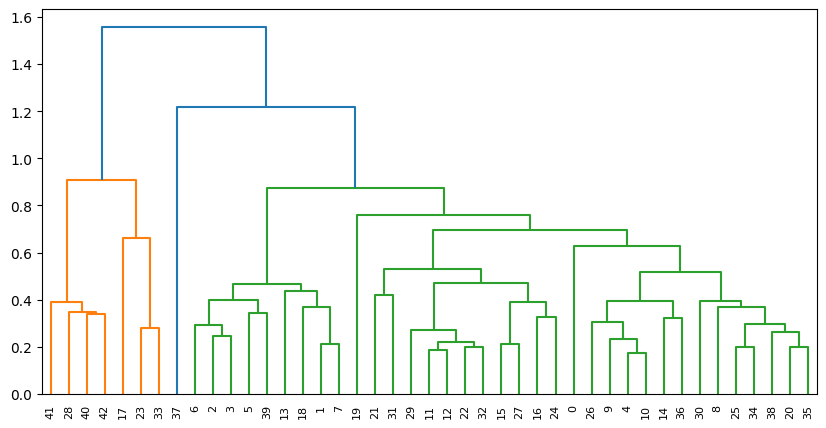

In [177]:
f,ax = plt.subplots(1,1,figsize=(10,5))
# dendrogram(Z, color_threshold=0.024)
dendrogram(Z, color_threshold=1.0)
plt.show()

In [173]:
tmp_list = []
tmp_labels = (fcluster(Z, t=0.024, criterion='distance'))

for j in eucl_df.index:
    if region2primaryRegion[j] == i:
        tmp_list.append(j)

tmp_labels_df = pd.DataFrame({'region': tmp_list,
                              'label': tmp_labels
                             })
tmp_labels_df = tmp_labels_df.set_index('region')
tmp_labels_df = tmp_labels_df.iloc[leaves_list(Z), ]
tmp_labels_df

,label
region,
PERI,4
ILA,3
TEa,1
ECT,2
VISal,7
VISli,5
AIp,6
RSPv,43
SSp-m,10


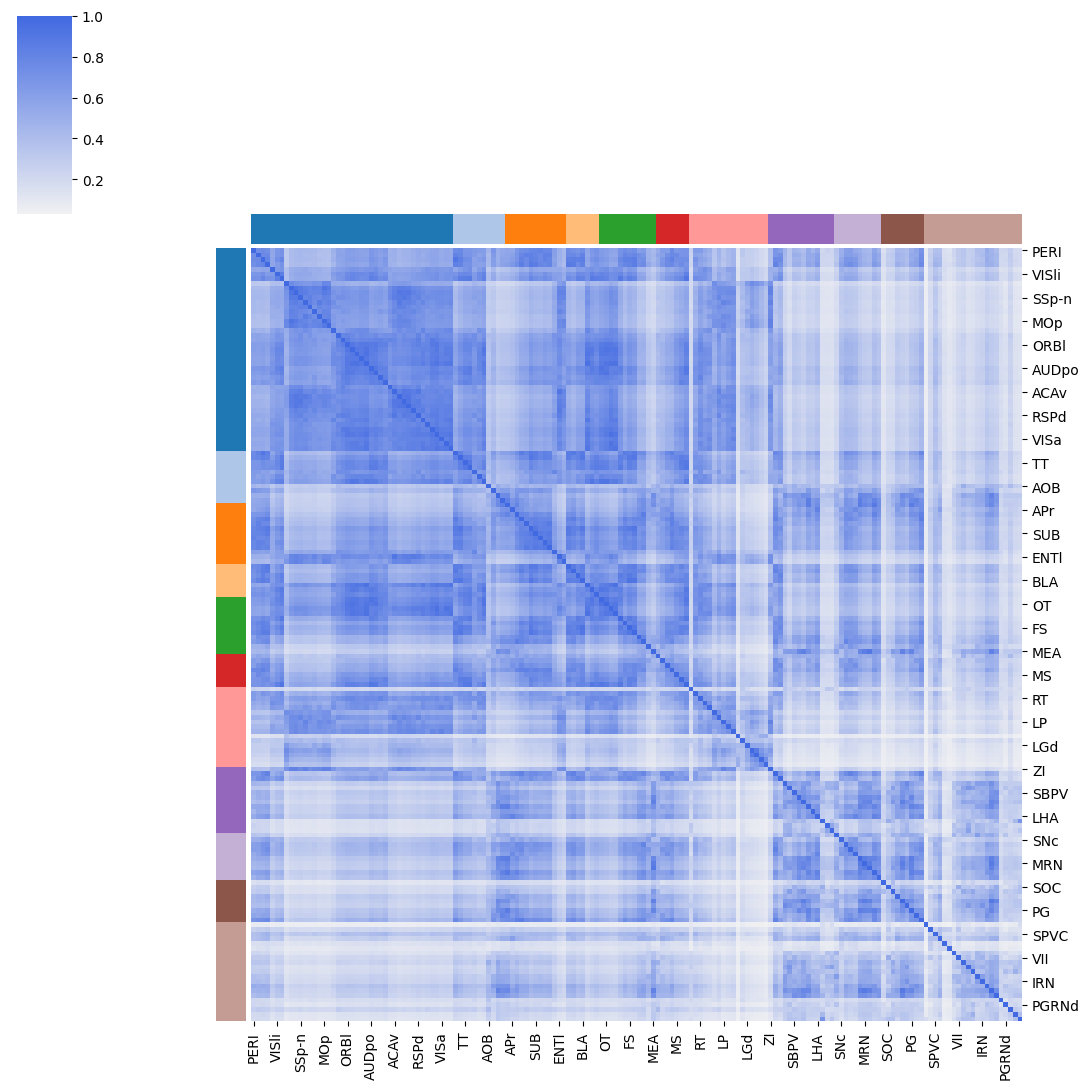

In [174]:
sns.clustermap(order_df, row_cluster=False, 
               col_cluster=False, 
               row_colors=color_list,
               col_colors=color_list,
               figsize=(11,11),
               cmap=sns.color_palette("light:royalblue", as_cmap=True)

              )

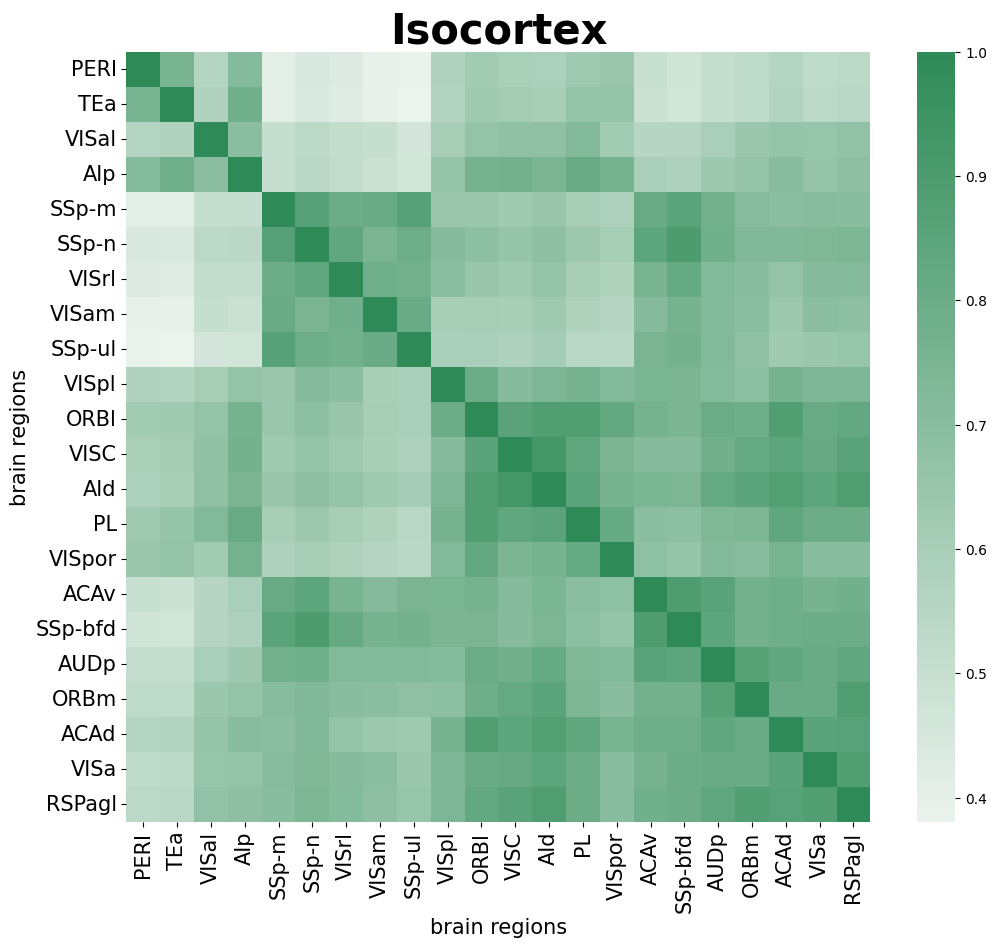

In [178]:
cur_region = 'Isocortex'

tmp_list = []
for i in order_df.index:
    if region2primaryRegion[i] == cur_region:
        tmp_list.append(i)
        
tmp_df = order_df.loc[tmp_list[::2], tmp_list[::2]].copy()

f,ax = plt.subplots(1,1,figsize=(12,10))
sns.heatmap(tmp_df,
            cmap=sns.color_palette("light:seagreen", as_cmap=True),
           )

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

ax.set_xlabel('brain regions', fontsize=15)
ax.set_ylabel('brain regions', fontsize=15)
plt.title(cur_region, fontsize=30, fontweight='bold')

ax.set_xticks(list(0.5+np.arange(len(tmp_df.columns))),
              tmp_df.columns, 
              rotation=90,
              fontsize=15)

ax.set_yticks(list(0.5+np.arange(len(tmp_df.index))),
              tmp_df.index, 
              rotation=0,
              fontsize=15)


plt.savefig('./'+cur_region+'_cluster.svg', bbox_inches='tight')